# Text Generation using RNNs

RNN Code modified (and simplified) from TensorFlow Website with additional challenges by John Tan Chong Min (2022).

Original Notebook at: https://www.tensorflow.org/text/tutorials/text_generation

This notebook generates 
Shakespearean text using a character-based RNN.

## Setup

### Import TensorFlow and other libraries

In [1]:
import tensorflow as tf

import numpy as np
import os
import time

### Download the Shakespeare dataset

Challenge 1: Change the following line to run this code on your own data.

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1130496/1115394 [==============================] - 0s 0us/step


### Read the data

First, look in the text:

In [3]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [4]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'A total of {len(vocab)} unique characters:')
print(sorted(list(set(text))))

A total of 65 unique characters:
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
char_to_num = {char: num for num, char in enumerate(vocab)}
num_to_char = {num: char for num, char in enumerate(vocab)}

# Split the input text and index the text

Pass the indexed text into a TensorFlow dataset, then make the dataset be in batches of *seq_length* + 1.

Within each batch, we then make the input text the first *seq_length* characters, and the output text is last *seq_length* characters (input right shifted by 1).

In [7]:
def get_text(index_list, default = ' '):
    ''' This gets back the text based on a list of indices 
    If index is not present in dictionary, defaults to ' ' '''
    return ''.join(num_to_char[k.numpy()] if k.numpy() in num_to_char else default for k in index_list)

def get_indices(char_list, default = 0):
    ''' This gets the indices based on the list of text 
    If character is not present in dictionary, defaults to index 0
    '''
    return [char_to_num[c] if c in char_to_num else default for c in char_list]

In [8]:
all_ids = get_indices(text)
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [9]:
# See the first 10 characters of the text
for ids in ids_dataset.take(10):
    print(ids, get_text([ids]))

tf.Tensor(18, shape=(), dtype=int32) F
tf.Tensor(47, shape=(), dtype=int32) i
tf.Tensor(56, shape=(), dtype=int32) r
tf.Tensor(57, shape=(), dtype=int32) s
tf.Tensor(58, shape=(), dtype=int32) t
tf.Tensor(1, shape=(), dtype=int32)  
tf.Tensor(15, shape=(), dtype=int32) C
tf.Tensor(47, shape=(), dtype=int32) i
tf.Tensor(58, shape=(), dtype=int32) t
tf.Tensor(47, shape=(), dtype=int32) i


In [10]:
seq_length = 100
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
for seq in sequences.take(1):
    print('Indexed Sequence:')
    print(seq)
    print('Actual Sequence:')
    print([get_text(seq)])

Indexed Sequence:
tf.Tensor(
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1], shape=(101,), dtype=int32)
Actual Sequence:
['First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou ']


In [11]:
def split_input_target(sequence):
    input_text = tf.squeeze(sequence[:-1])
    target_text = tf.squeeze(sequence[1:])
    return input_text, target_text

In [12]:
dataset = sequences.map(split_input_target)

In [13]:
for input_example, target_example in dataset.take(1):
    print("Input shape:", input_example.shape)
    print("Output shape:", target_example.shape)
    print("Input :", [get_text(input_example)])
    print("Target:", [get_text(target_example)])

Input shape: (100,)
Output shape: (100,)
Input : ['First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou']
Target: ['irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou ']


# Creating suitably-sized datasets

Add in a buffer so that we do not load the entire dataset at one go (this dataset is huge).
We also add in batching for faster training.

In [14]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

## Build The Model

For each character the model looks up the embedding, we run the GRU one timestep with the embedding as input, and apply the dense layer to generate logits predicting the log-likelihood of the next character:

![A drawing of the data passing through the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/text_generation_training.png?raw=1)

This model has three layers:

* `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map each character-ID to a vector with `embedding_dim` dimensions;
* `tf.keras.layers.GRU`: A type of RNN with size `units=rnn_units` (You can also use an LSTM layer here.)
* `tf.keras.layers.Dense`: The output layer, with `vocab_size` outputs. It outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model.

The model takes in an entire *seq_length* of text as an input (can be any length), and outputs logit probabilities of the next character for each character of the input.

In [15]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN hidden nodes
rnn_units = 1024

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(batch_input_shape = (None, None)),
    tf.keras.layers.Embedding(vocab_size, embedding_dim), 
    # Let us create a GRU layer which returns all intermediate sequences
    # Challenge 2: For RNN use tf.keras.layers.SimpleRNN, For LSTM use tf.keras.layers.LSTM
    tf.keras.layers.GRU(rnn_units, return_sequences = True), # Note you can also try out RNN or LSTM
    tf.keras.layers.Dense(vocab_size, activation = tf.nn.softmax)]
)

We can also run a similar code using the Functional API. Check it out by uncommenting the cell below!

In [17]:
# inputs = tf.keras.layers.Input(batch_input_shape = (None, None))
# x = tf.keras.layers.Embedding(vocab_size, embedding_dim)(inputs)
# x = tf.keras.layers.GRU(rnn_units, return_sequences = True)(x)
# outputs = tf.keras.layers.Dense(vocab_size, activation = tf.nn.softmax)(x)
# model = tf.keras.Model(inputs = inputs, outputs = outputs)

In the above example the sequence length of the input is `100` but the model can be run on inputs of any length:

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         16640     
                                                                 
 gru (GRU)                   (None, None, 1024)        3938304   
                                                                 
 dense (Dense)               (None, None, 65)          66625     
                                                                 
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


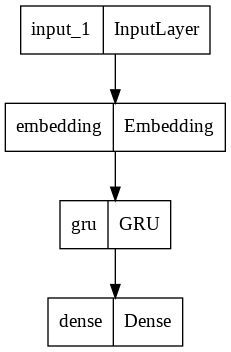

In [19]:
tf.keras.utils.plot_model(model)

In [20]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
for i, o in dataset.take(1):
  print('Input (with batch dimension) shape:', i.shape, 'Output (with batch dimension) shape:', o.shape)

Input (with batch dimension) shape: (64, 100) Output (with batch dimension) shape: (64, 100)


In [22]:
model.fit(dataset, epochs=5)

Epoch 1/5
172/172 [==============================] - 32s 140ms/step - loss: 2.7301 - accuracy: 0.2781
Epoch 2/5
172/172 [==============================] - 25s 138ms/step - loss: 1.9905 - accuracy: 0.4181
Epoch 3/5
172/172 [==============================] - 25s 138ms/step - loss: 1.7145 - accuracy: 0.4915
Epoch 4/5
172/172 [==============================] - 25s 137ms/step - loss: 1.5539 - accuracy: 0.5338
Epoch 5/5
172/172 [==============================] - 25s 137ms/step - loss: 1.4550 - accuracy: 0.5595


To get actual predictions from the model you need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

Note: It is important to _sample_ from this distribution as taking the _argmax_ of the distribution can easily get the model stuck in a loop.

## Generate text

We will feed in an input of one character, and ask the model to predict the next character.

The next character is sampled based on the logits output at the current time step, and fed to the model in the next time step.


For the next character, we will feed in the entire set of characters from start time till that character, and ask the model to do the prediction. (NOTE: We could also do it by passing the model's internal state each time step to the next time step, and then just pass through one character, but doing so will require to do more complicated modelling.)

![To generate text the model's output is fed back to the input](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/text_generation_sampling.png?raw=1)

In [23]:
def generate_next_char(input_text = "ROMEO:", temp = 0.02):

  ''' Given the input text, generate the next character
  Inputs: 
  input_text (str): The text from start till now
  temp (float): Controls how random the sampling is (< 1: similar to argmax, > 1: more random, = 1: original softmax probabilities)
  '''

  predicted_logits = model(tf.reshape(tf.convert_to_tensor(get_indices(input_text)), (1, -1)))

  # Only use the last logit prediction
  predicted_logits = predicted_logits[:, -1, :]
  predicted_logits = predicted_logits/temp

  # Sample the output logits to generate token IDs.
  predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)[0]
  return get_text(predicted_ids)

In [24]:
print(generate_next_char("ROMEO: "))

I


Run it in a loop to generate some text. Looking at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [25]:
start = time.time()
num_char = 400      # Number of characters to generate
num_prev_char = 100 # Number of previous characters to focus on
mytext = "ROMEO:"

for n in range(num_char):
  next_char = generate_next_char(mytext[-num_prev_char:])
  mytext += next_char

print(mytext)
end = time.time()
print('\nRun time:', end - start)

ROMEO:
The first thou hast not so the world in the brother
That the matter that the prince of his country,
That have been so fair and all the seatest of the wind
That have been so fair and unto the prince.

KING RICHARD III:
What should be so for the sentence of the seaters of the Bolingbroke.

KING RICHARD III:
The sent the prince of his country and the prince of his country
That which the best of the 

Run time: 6.238189697265625


# Additional Challenges

Have fun playing around with this code and learn about RNNs!

- Challenge 1: Use your own dataset and run the code to see if it can fit to your dataset
- Challenge 2: Change the code to LSTM / RNN and test out which is better
- Challenge 3: See if you can improve the output plausibility by modifying the embedding_dim, rnn_units, or epochs. (Hint: epochs is the most straightforward)


For Challenge 2, for the same number of training epochs, you will find that LSTM/GRU model outputs are significantly better than those of RNN. This may be due to the "vanishing/exploding" gradient problem in the vanilla RNN.

# Advanced Challenge
Can the model still work if we replace the Embedding Layer with One Hot Encoding instead?

In [26]:
preprocessing_layer = tf.keras.layers.CategoryEncoding(vocab_size, 'one_hot')

dataset2 = sequences.map(split_input_target)
dataset2 = (
    dataset2
    .map(lambda x, y: (preprocessing_layer(x), y))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [27]:
for i, o in dataset2.take(1):
  print(i.shape, o.shape)

(64, 100, 65) (64, 100)


Redo the model with the new one-hot-encoding prepocessing and remove Embedding layer.

In [28]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(batch_input_shape = (None, None, vocab_size)),
    tf.keras.layers.GRU(rnn_units, return_sequences = True), 
    tf.keras.layers.Dense(vocab_size, activation = tf.nn.softmax)]
)

In [29]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, None, 1024)        3351552   
                                                                 
 dense_1 (Dense)             (None, None, 65)          66625     
                                                                 
Total params: 3,418,177
Trainable params: 3,418,177
Non-trainable params: 0
_________________________________________________________________


In [30]:
model2.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
model2.fit(dataset2, epochs=5)

Epoch 1/5
172/172 [==============================] - 25s 125ms/step - loss: 2.8971 - accuracy: 0.2465
Epoch 2/5
172/172 [==============================] - 24s 126ms/step - loss: 2.1988 - accuracy: 0.3705
Epoch 3/5
172/172 [==============================] - 24s 125ms/step - loss: 2.0188 - accuracy: 0.4154
Epoch 4/5
172/172 [==============================] - 24s 125ms/step - loss: 1.8677 - accuracy: 0.4520
Epoch 5/5
172/172 [==============================] - 24s 125ms/step - loss: 1.7437 - accuracy: 0.4835


In [32]:
def generate_next_char_onehot(input_text = "ROMEO:", temp = 0.02):

  ''' Given the input text, generate the next character using one-hot encoding
  Inputs: 
  input_text (str): The text from start till now
  temp (float): Controls how random the sampling is (< 1: similar to argmax, > 1: more random, = 1: original softmax probabilities)
  '''

  indices = tf.reshape(tf.convert_to_tensor(get_indices(input_text)), (1, -1))
  predicted_logits = model2(tf.one_hot(indices, vocab_size))

  # Only use the last logit prediction
  predicted_logits = predicted_logits[:, -1, :]
  predicted_logits = predicted_logits/temp

  # Sample the output logits to generate token IDs.
  predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)[0]
  return get_text(predicted_ids)

In [33]:
start = time.time()
num_char = 400      # Number of characters to generate
num_prev_char = 100 # Number of previous characters to focus on
mytext = "ROMEO:"

for n in range(num_char):
  next_char = generate_next_char_onehot(mytext[-num_prev_char:])
  mytext += next_char

print(mytext)
end = time.time()
print('\nRun time:', end - start)

ROMEO:
I have be the stand of the come,
And be the will be sone to see the rester with a mand
That shall be sone and , and be the beath,
And the beath me the rest good man.

Second Catizen:
What is the read of the Ore the will be the death,
And we propest the death of the -and and the seath,
And shall be the will so mane and be the will.

KING HENRY VI:
What is the rest and be the couster of the reads,


Run time: 6.005336761474609


We can see that the generated text is not as good as that with Embeddings. Embedding Layers help to put the vocabulary into a relevant semantic space to help it to generate better text.

Even in a character-level model, similar character (capital or non-capital) may be semantically related, so they can be grouped in the same semantic space for better generalization.